# 00 Getting setup

In [1]:
import torch
import torch.nn as nn
import helper_functions
import importlib

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 00.1 Downloading the Data


In [2]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path

os.environ['KAGGLE_CONFIG_DIR'] = 'C:\\Users\\loq\\.kaggle'

api = KaggleApi()
api.authenticate()

data_path = Path("data/")
audio_path = data_path / "Data"

dataset = 'andradaolteanu/gtzan-dataset-music-genre-classification'

if audio_path.is_dir():
    print("Data already exists, skipping dawnload...")
else:    
    print("Downloading data...")
    api.dataset_download_files(dataset, path=data_path, unzip=True)

Data already exists, skipping dawnload...


### 00.2 Walking through the directory

In [3]:
importlib.reload(helper_functions)
from helper_functions import walk_through_dir

In [4]:
genres_original_path = audio_path / 'genres_original'

walk_through_dir(genres_original_path)

There are 10 directories and 0 audios in data\Data\genres_original
There are 0 directories and 100 audios in data\Data\genres_original\blues
There are 0 directories and 100 audios in data\Data\genres_original\classical
There are 0 directories and 100 audios in data\Data\genres_original\country
There are 0 directories and 100 audios in data\Data\genres_original\disco
There are 0 directories and 100 audios in data\Data\genres_original\hiphop
There are 0 directories and 99 audios in data\Data\genres_original\jazz
There are 0 directories and 100 audios in data\Data\genres_original\metal
There are 0 directories and 100 audios in data\Data\genres_original\pop
There are 0 directories and 100 audios in data\Data\genres_original\reggae
There are 0 directories and 100 audios in data\Data\genres_original\rock


# Getting data ready

### Creating spectogram on a single sample 

Shape y: (661794,)
Shape S: (128, 1293)
Shape S_db: (128, 1293)


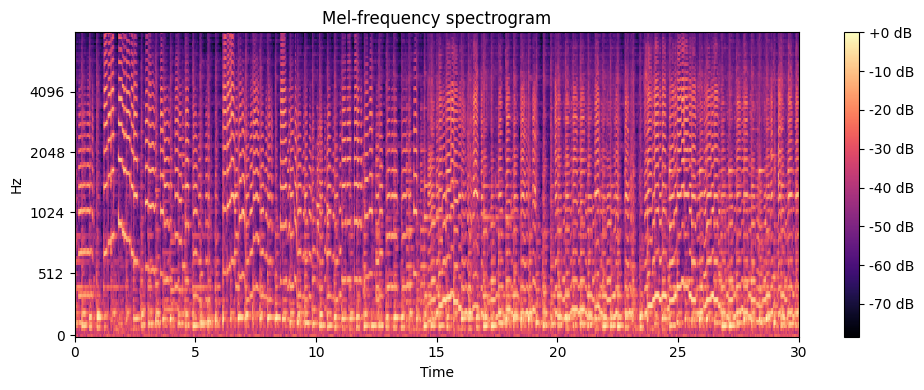

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_path = 'data/Data/genres_original/jazz/jazz.00053.wav'

y, sr = librosa.load(audio_path, sr=22050)  # y — signal, sr — sample rate
print(f"Shape y: {y.shape}")

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
print(f"Shape S: {S.shape}")

S_dB = librosa.power_to_db(S, ref=np.max)
print(f"Shape S_db: {S_dB.shape}")

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [6]:
y.shape, S.shape, S_dB.shape

((661794,), (128, 1293), (128, 1293))

In [7]:
import torchaudio
from torchaudio import transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [8]:
from helper_functions import find_classes
class_names, class_to_idx = find_classes(genres_original_path)

In [9]:
class AudioFolderCustom(Dataset):
    def __init__(self,
                 targ_dir: Path,
                 target_length: int,
                 transform=None,
                 percentage: Tuple[int, int]= (0.0, 1.0),
                 ):
        
        super().__init__()
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
        self.target_length = target_length
        all_paths = []
        targ_dir = Path(targ_dir)

        for cls_name in self.classes:
            cls_folder = targ_dir / cls_name
            wav_files = sorted(cls_folder.glob('*.wav'))
            start_files = int(len(wav_files) * percentage[0])
            end_files = int(len(wav_files) * percentage[1])
            selected_files = wav_files[start_files:end_files]
            all_paths.extend(selected_files)

        self.paths = all_paths
        

    def __len__(self):
        return len(self.paths) 

    def __getitem__(self, idx):
        filepath= self.paths[idx]
        class_name = filepath.parent.name
        class_idx = self.class_to_idx[class_name]
        waveform, sample_rate = torchaudio.load(filepath)
        if self.transform:
            waveform = self.transform(waveform)
        #     waveform = librosa.feature.melspectrogram(y=waveform, 
        #                                               sr=sample_rate, 
        #                                               n_fft=2048,
        #                                               hop_length=512, 
        #                                               n_mels=128, 
        #                                               fmax=8000)
            
        #     waveform = librosa.power_to_db(waveform, ref=np.max)

        # waveform = torch.from_numpy(waveform).type(torch.float32).unsqueeze(dim=0)
        current_length = waveform.shape[2]
        if current_length > self.target_length:
            waveform = waveform[:, :, :self.target_length]
        elif current_length < self.target_length:
            pad_len = self.target_length - current_length
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))


        return waveform, class_idx  

In [10]:
class NormalizeDBRange(torch.nn.Module):
    def __init__(self, min_db: float = -60.0, max_db: float = 40.0):
        super().__init__()
        self.min_db = min_db
        self.max_db = max_db

    def forward(self, x):
        x = torch.clamp(x, min=self.min_db, max=self.max_db)
        x = (x - self.min_db) / (self.max_db - self.min_db)
        return x

22050
torch.Size([1, 128, 1293])


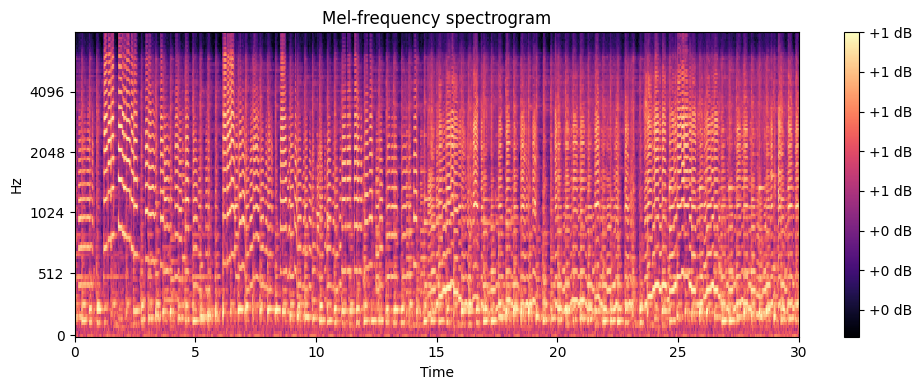

In [11]:

train_transform = nn.Sequential(
    transforms.MelSpectrogram(
        sample_rate=22050,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40)
)

test_transform = nn.Sequential(
    transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    hop_length=512,
    n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40)
)

waveform, sample_rate = torchaudio.load(audio_path)
print(sample_rate)
transformed_audio = train_transform(waveform)
print(transformed_audio.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(transformed_audio.squeeze().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


In [12]:
target_length = 1000

train_data_custom = AudioFolderCustom(targ_dir=genres_original_path,
                                      target_length=target_length,
                                      transform=train_transform,
                                      percentage=(0.0, 0.4))

test_data_custom = AudioFolderCustom(targ_dir=genres_original_path,
                                     target_length=target_length,
                                     transform=test_transform,
                                     percentage=(0.4, 0.5))
train_data_custom, test_data_custom, len(train_data_custom), len(test_data_custom)

(<__main__.AudioFolderCustom at 0x24a213bfda0>,
 399,
 100)

In [13]:
train_data_custom.class_to_idx

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [14]:
train_data_custom[0][0]

tensor([[[0.7348, 0.6596, 0.6186,  ..., 0.6015, 0.5739, 0.6303],
         [0.7925, 0.7648, 0.7243,  ..., 0.7194, 0.7113, 0.7664],
         [0.7731, 0.7887, 0.7918,  ..., 0.8473, 0.8428, 0.8513],
         ...,
         [0.3223, 0.2631, 0.1320,  ..., 0.1722, 0.1609, 0.1937],
         [0.3228, 0.2628, 0.0388,  ..., 0.0594, 0.0603, 0.1223],
         [0.3225, 0.2624, 0.0017,  ..., 0.0098, 0.0032, 0.0312]]])

In [15]:
train_data_custom[0][0].max(), train_data_custom[0][0].min()

(tensor(1.), tensor(0.))

In [16]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0

torch.manual_seed(19)
train_dataloader = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x24a254ebdd0>,
 13,
 4)

In [17]:
audio, label = next(iter(test_dataloader))
audio.shape, label.shape

(torch.Size([32, 1, 128, 1000]), torch.Size([32]))

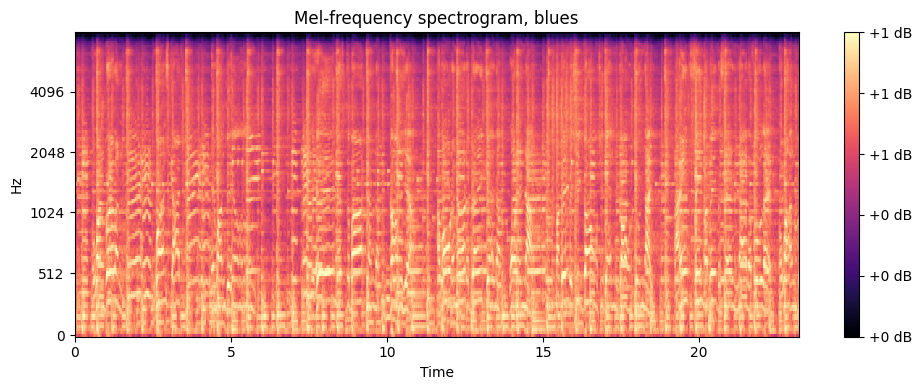

In [18]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_data_custom[0][0].squeeze().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram, {class_names[train_data_custom[0][1]]}')
plt.tight_layout()
plt.show()

In [19]:
import importlib
import models.cnn_genre as cnn

importlib.reload(cnn)


<module 'models.cnn_genre' from 'c:\\Users\\loq\\Documents\\Deep Learning\\Audio-Classification-GTZAN\\models\\cnn_genre.py'>

In [20]:
torch.manual_seed(19)
model_0 = cnn.AudioCNN_0(input_shape=1, 
                     hidden_units=16, 
                     output_shape=10).to(device)

model_0

AudioCNN_0(
  (conv2d_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [21]:
train_data_custom[0][0].shape

torch.Size([1, 128, 1000])

In [22]:
model_0.eval()
with torch.inference_mode():

    y_pred = model_0(train_data_custom[0][0].unsqueeze(dim=0).to(device))
    print(y_pred)
    print(torch.softmax(y_pred, dim=1))
    label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    print(class_names[label])
    label = torch.argmax(y_pred, dim=1)
    print(class_names[label])

tensor([[-0.0925,  0.0727, -0.0683, -0.0517,  0.0359,  0.0423,  0.0015, -0.0641,
         -0.0568,  0.0645]], device='cuda:0')
tensor([[0.0921, 0.1086, 0.0943, 0.0959, 0.1047, 0.1054, 0.1011, 0.0947, 0.0954,
         0.1077]], device='cuda:0')
classical
classical


In [23]:

import torchinfo
from torchinfo import summary

summary(model_0, input_size=[1,1,128,1000])

Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_0                               [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 250]          --
│    └─Conv2d: 2-1                       [1, 16, 129, 1001]        80
│    └─BatchNorm2d: 2-2                  [1, 16, 129, 1001]        32
│    └─ReLU: 2-3                         [1, 16, 129, 1001]        --
│    └─MaxPool2d: 2-4                    [1, 16, 32, 250]          --
├─Sequential: 1-2                        [1, 32, 8, 62]            --
│    └─Conv2d: 2-5                       [1, 32, 33, 251]          2,080
│    └─BatchNorm2d: 2-6                  [1, 32, 33, 251]          64
│    └─ReLU: 2-7                         [1, 32, 33, 251]          --
│    └─MaxPool2d: 2-8                    [1, 32, 8, 62]            --
├─Sequential: 1-3                        [1, 64, 2, 15]            --
│    └─Conv2d: 2-9                       [1, 64, 9, 63]            8,256
│    └─Ba

In [24]:
from torch.utils.data import dataloader
from helper_functions import train
    

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10,
      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.4418, Train acc: 0.2008 | Test loss: 2.2188, Test acc: 0.2969
Epoch: 1 | Train loss 1.6919, Train acc: 0.3433 | Test loss: 2.1616, Test acc: 0.1953
Epoch: 2 | Train loss 1.4000, Train acc: 0.4563 | Test loss: 2.1501, Test acc: 0.2266
Epoch: 3 | Train loss 1.1421, Train acc: 0.5829 | Test loss: 2.1417, Test acc: 0.3359
Epoch: 4 | Train loss 1.0813, Train acc: 0.5561 | Test loss: 2.3079, Test acc: 0.3125
Epoch: 5 | Train loss 0.9481, Train acc: 0.6615 | Test loss: 2.3303, Test acc: 0.3047
Epoch: 6 | Train loss 0.8866, Train acc: 0.6450 | Test loss: 2.1504, Test acc: 0.2812
Epoch: 7 | Train loss 0.7717, Train acc: 0.7054 | Test loss: 2.4246, Test acc: 0.3047
Epoch: 8 | Train loss 0.7573, Train acc: 0.7240 | Test loss: 2.0400, Test acc: 0.3203
Epoch: 9 | Train loss 0.7338, Train acc: 0.7704 | Test loss: 2.9026, Test acc: 0.2266


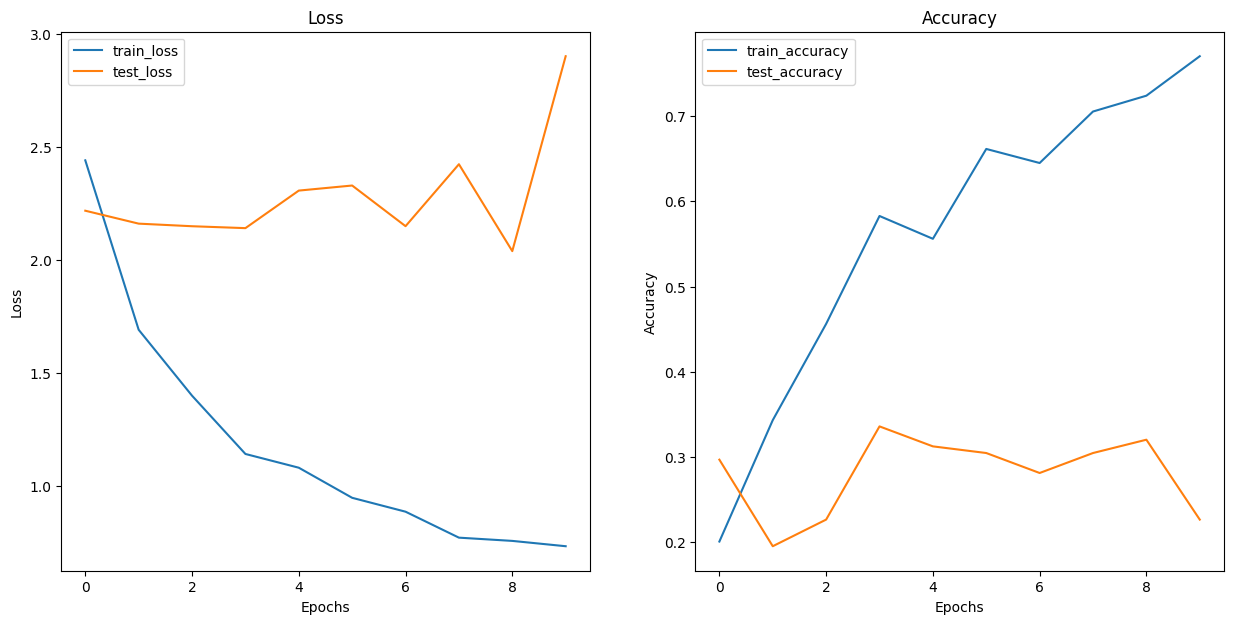

In [26]:
from helper_functions import plot_loss_curves, make_predictions
plot_loss_curves(model_0_results)

In [28]:
make_predictions(model=model_0,
                 class_names=class_names,
                 data=test_data_custom,
                 n=10)

make_predictions(model=model_0,
                 class_names=class_names,
                 data=train_data_custom,
                 n=10)


Prediction genre: pop | True genre: hiphop
Prediction genre: country | True genre: country
Prediction genre: pop | True genre: reggae
Prediction genre: pop | True genre: reggae
Prediction genre: country | True genre: reggae
Prediction genre: pop | True genre: hiphop
Prediction genre: rock | True genre: metal
Prediction genre: jazz | True genre: jazz
Prediction genre: country | True genre: classical
Prediction genre: country | True genre: rock
-----------
Correct preditions: 2 out of 10
-----------
Prediction genre: country | True genre: disco
Prediction genre: country | True genre: country
Prediction genre: country | True genre: disco
Prediction genre: country | True genre: disco
Prediction genre: reggae | True genre: reggae
Prediction genre: reggae | True genre: rock
Prediction genre: country | True genre: country
Prediction genre: blues | True genre: reggae
Prediction genre: reggae | True genre: reggae
Prediction genre: metal | True genre: hiphop
-----------
Correct preditions: 4 out

In [29]:
importlib.reload(cnn)

torch.manual_seed(19)
model_1 = cnn.AudioCNN_1(input_shape=1,
                     hidden_units=16,
                     output_shape=len(class_names)).to(device)

summary(model_1, input_size=[1,1,128,1000])


Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_1                               [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 250]          --
│    └─Conv2d: 2-1                       [1, 16, 129, 1001]        80
│    └─BatchNorm2d: 2-2                  [1, 16, 129, 1001]        32
│    └─ReLU: 2-3                         [1, 16, 129, 1001]        --
│    └─MaxPool2d: 2-4                    [1, 16, 32, 250]          --
├─Sequential: 1-2                        [1, 32, 8, 62]            --
│    └─Conv2d: 2-5                       [1, 32, 33, 251]          2,080
│    └─BatchNorm2d: 2-6                  [1, 32, 33, 251]          64
│    └─ReLU: 2-7                         [1, 32, 33, 251]          --
│    └─MaxPool2d: 2-8                    [1, 32, 8, 62]            --
├─Sequential: 1-3                        [1, 64, 2, 15]            --
│    └─Conv2d: 2-9                       [1, 64, 9, 63]            8,256
│    └─Ba

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss 0.9320, Train acc: 0.6598 | Test loss: 2.5357, Test acc: 0.1953
Epoch: 1 | Train loss 0.6284, Train acc: 0.7593 | Test loss: 2.2994, Test acc: 0.3047
Epoch: 2 | Train loss 0.5719, Train acc: 0.7950 | Test loss: 2.5779, Test acc: 0.3125
Epoch: 3 | Train loss 0.4453, Train acc: 0.8572 | Test loss: 2.6599, Test acc: 0.2656
Epoch: 4 | Train loss 0.4168, Train acc: 0.8494 | Test loss: 2.8889, Test acc: 0.3047
Epoch: 5 | Train loss 0.3251, Train acc: 0.8998 | Test loss: 2.0078, Test acc: 0.4453
Epoch: 6 | Train loss 0.3100, Train acc: 0.8987 | Test loss: 2.5472, Test acc: 0.3125
Epoch: 7 | Train loss 0.2942, Train acc: 0.9176 | Test loss: 2.5817, Test acc: 0.3281
Epoch: 8 | Train loss 0.2632, Train acc: 0.9128 | Test loss: 2.4124, Test acc: 0.3203
Epoch: 9 | Train loss 0.2193, Train acc: 0.9540 | Test loss: 2.3676, Test acc: 0.3281


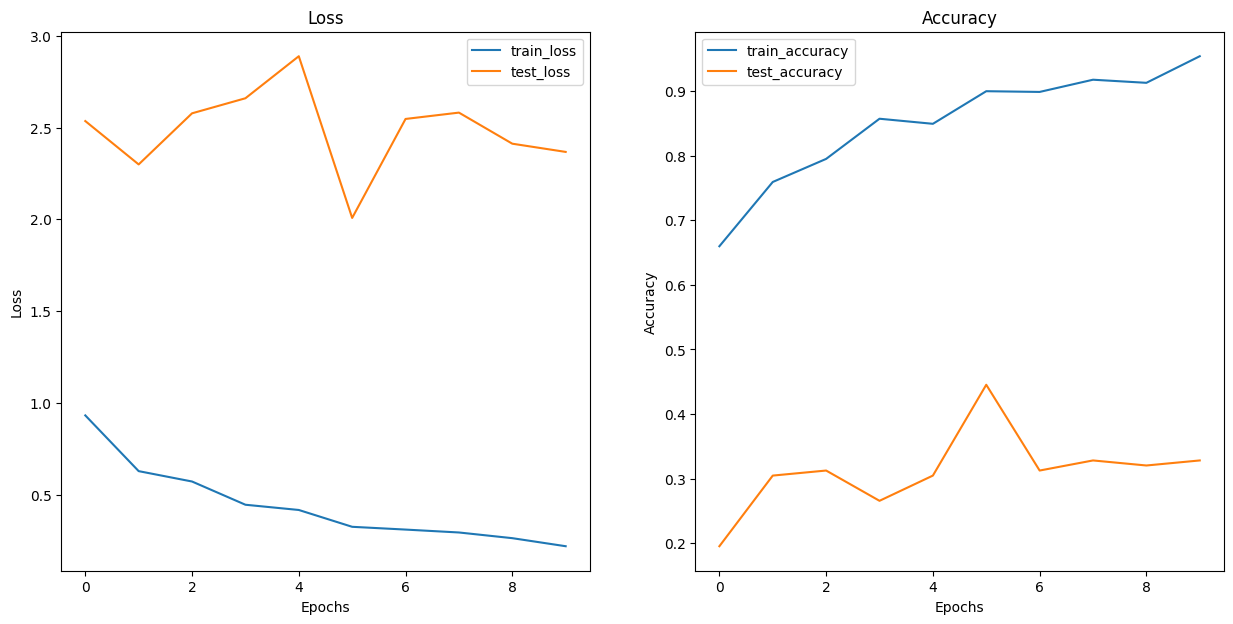

In [32]:
plot_loss_curves(model_1_results)

In [33]:
train_transform_with_augmentation = nn.Sequential(
    transforms.MelSpectrogram(
        sample_rate=22050,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40),
    transforms.FrequencyMasking(freq_mask_param=15),
    transforms.TimeMasking(time_mask_param=50),
    #transforms.Vol(gain=0.8, gain_type='amplitude')
)

test_transform = nn.Sequential(
    transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    hop_length=512,
    n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40)
)

train_data_augmented = AudioFolderCustom(targ_dir=genres_original_path,
                                                       target_length=1000,
                                                       transform=train_transform_with_augmentation,
                                                       percentage=(0, 0.8))

test_data = AudioFolderCustom(targ_dir=genres_original_path,
                                    target_length=1000,
                                    transform=test_transform,
                                    percentage=(0.8, 1.0))

print(train_data_augmented[0][0])

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)


train_dataloader_augmented, test_dataloader

tensor([[[0.7348, 0.6596, 0.6186,  ..., 0.6015, 0.5739, 0.6303],
         [0.7925, 0.7648, 0.7243,  ..., 0.7194, 0.7113, 0.7664],
         [0.7731, 0.7887, 0.7918,  ..., 0.8473, 0.8428, 0.8513],
         ...,
         [0.3223, 0.2631, 0.1320,  ..., 0.1722, 0.1609, 0.1937],
         [0.3228, 0.2628, 0.0388,  ..., 0.0594, 0.0603, 0.1223],
         [0.3225, 0.2624, 0.0017,  ..., 0.0098, 0.0032, 0.0312]]])


(<torch.utils.data.dataloader.DataLoader at 0x24a251ab830>,
 <torch.utils.data.dataloader.DataLoader at 0x24a22989f40>)

In [34]:
len(train_data_augmented), len(test_data), len(train_dataloader_augmented), len(test_dataloader)

(799, 200, 25, 7)

In [35]:
next(iter(train_dataloader_augmented))

[tensor([[[[0.7416, 0.6819, 0.5087,  ..., 0.4487, 0.4519, 0.5094],
           [0.7563, 0.6978, 0.5705,  ..., 0.7676, 0.7617, 0.7575],
           [0.7443, 0.6901, 0.6638,  ..., 0.8742, 0.8701, 0.8669],
           ...,
           [0.4268, 0.3674, 0.2309,  ..., 0.1283, 0.1352, 0.1080],
           [0.4271, 0.3670, 0.1367,  ..., 0.0317, 0.0080, 0.0279],
           [0.4272, 0.3670, 0.0188,  ..., 0.0253, 0.0119, 0.0070]]],
 
 
         [[[0.9426, 0.9136, 0.8617,  ..., 0.6943, 0.8131, 0.8121],
           [0.8884, 0.9196, 0.9319,  ..., 0.8077, 0.8544, 0.9024],
           [0.8096, 0.8302, 0.8651,  ..., 0.8450, 0.9018, 0.9000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.8313, 0.8618, 0.8757,  ..., 0.7937, 0.8647, 0.8703],
           [0.8295, 0.8469, 0.8647,  ..., 0.7702, 0.8458, 0.8479]]],
 
 
         [[[0.6766, 0.7120, 0.6745,  ..., 0.6416, 0.6547, 0.6967],
           [0.6841, 0.8128, 0.9131,  ..., 0.9167, 0.8722, 0.7322],
           [0.7044

In [36]:
importlib.reload(cnn)
torch.manual_seed(19)
model_1_1 = cnn.AudioCNN_1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1_1.parameters(), lr=0.001)

model_1_1_results = train(model=model_1_1,
                          train_dataloader=train_dataloader_augmented,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=10,
                          device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.4290, Train acc: 0.1754 | Test loss: 2.4492, Test acc: 0.1830
Epoch: 1 | Train loss 1.7730, Train acc: 0.3717 | Test loss: 2.3806, Test acc: 0.2054
Epoch: 2 | Train loss 1.5048, Train acc: 0.4545 | Test loss: 1.6930, Test acc: 0.3170
Epoch: 3 | Train loss 1.2856, Train acc: 0.5319 | Test loss: 1.8546, Test acc: 0.3125
Epoch: 4 | Train loss 1.1905, Train acc: 0.5720 | Test loss: 1.7055, Test acc: 0.4107
Epoch: 5 | Train loss 1.0468, Train acc: 0.6446 | Test loss: 1.5433, Test acc: 0.4062
Epoch: 6 | Train loss 1.0098, Train acc: 0.6420 | Test loss: 1.6491, Test acc: 0.4375
Epoch: 7 | Train loss 0.9229, Train acc: 0.6833 | Test loss: 1.8387, Test acc: 0.4732
Epoch: 8 | Train loss 0.8283, Train acc: 0.7222 | Test loss: 2.7311, Test acc: 0.3259
Epoch: 9 | Train loss 0.8042, Train acc: 0.7347 | Test loss: 2.0564, Test acc: 0.4062


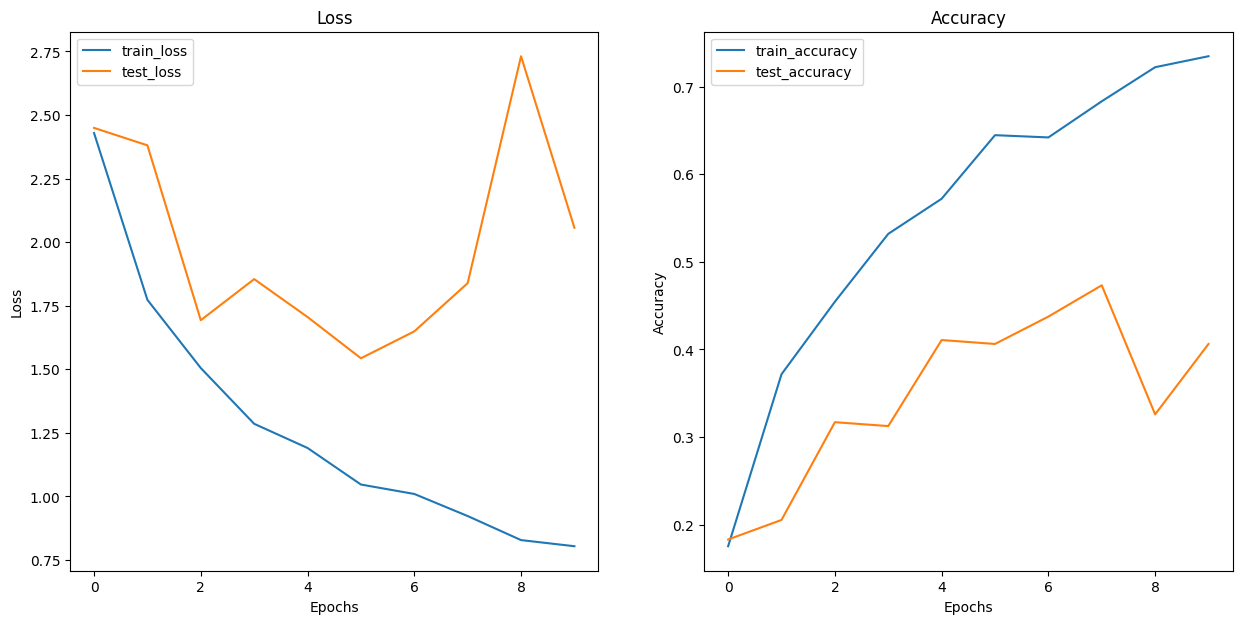

In [37]:
plot_loss_curves(model_1_1_results)

In [39]:
make_predictions(model_1_1,test_data, class_names)

Prediction genre: country | True genre: country
Prediction genre: country | True genre: disco
Prediction genre: country | True genre: rock
Prediction genre: country | True genre: blues
Prediction genre: blues | True genre: blues
Prediction genre: blues | True genre: disco
Prediction genre: blues | True genre: reggae
Prediction genre: country | True genre: country
Prediction genre: classical | True genre: classical
Prediction genre: rock | True genre: rock
-----------
Correct preditions: 5 out of 10
-----------


In [40]:
importlib.reload(cnn)
torch.manual_seed(19)
model_2 = cnn.AudioCNN_2(hidden_units=8).to(device)

summary(model_2, input_size=[1,1,128,1000])

Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_2                               [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 43, 333]           --
│    └─Conv2d: 2-1                       [1, 8, 129, 1001]         40
│    └─BatchNorm2d: 2-2                  [1, 8, 129, 1001]         16
│    └─ReLU: 2-3                         [1, 8, 129, 1001]         --
│    └─MaxPool2d: 2-4                    [1, 8, 43, 333]           --
├─Sequential: 1-2                        [1, 16, 14, 111]          --
│    └─Conv2d: 2-5                       [1, 16, 44, 334]          528
│    └─BatchNorm2d: 2-6                  [1, 16, 44, 334]          32
│    └─ReLU: 2-7                         [1, 16, 44, 334]          --
│    └─MaxPool2d: 2-8                    [1, 16, 14, 111]          --
├─Sequential: 1-3                        [1, 32, 5, 37]            --
│    └─Conv2d: 2-9                       [1, 32, 15, 112]          2,080
│    └─Batc

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.3165, Train acc: 0.1977 | Test loss: 2.4494, Test acc: 0.1295
Epoch: 1 | Train loss 1.9938, Train acc: 0.2944 | Test loss: 2.0699, Test acc: 0.2098
Epoch: 2 | Train loss 1.7569, Train acc: 0.3691 | Test loss: 1.9129, Test acc: 0.2143
Epoch: 3 | Train loss 1.4054, Train acc: 0.5019 | Test loss: 1.8251, Test acc: 0.3482
Epoch: 4 | Train loss 1.2649, Train acc: 0.5468 | Test loss: 1.5279, Test acc: 0.4688
Epoch: 5 | Train loss 1.0344, Train acc: 0.6408 | Test loss: 1.9499, Test acc: 0.3527
Epoch: 6 | Train loss 0.9431, Train acc: 0.6798 | Test loss: 1.5695, Test acc: 0.4598
Epoch: 7 | Train loss 0.8986, Train acc: 0.6683 | Test loss: 1.5038, Test acc: 0.5045
Epoch: 8 | Train loss 0.7740, Train acc: 0.7359 | Test loss: 1.3143, Test acc: 0.5089
Epoch: 9 | Train loss 0.7339, Train acc: 0.7573 | Test loss: 1.2990, Test acc: 0.5402
Epoch: 10 | Train loss 0.7194, Train acc: 0.7473 | Test loss: 1.5852, Test acc: 0.5045
Epoch: 11 | Train loss 0.6327, Train acc: 0.7684 | Te

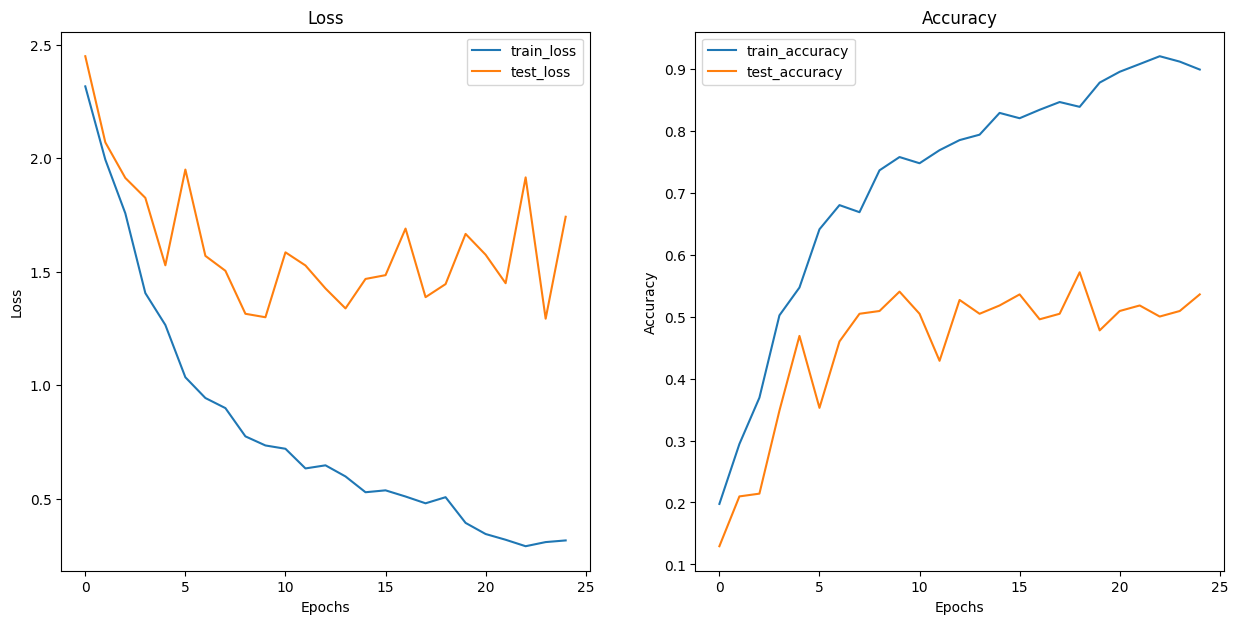

In [42]:
plot_loss_curves(model_2_results)

  0%|          | 0/200 [00:00<?, ?it/s]

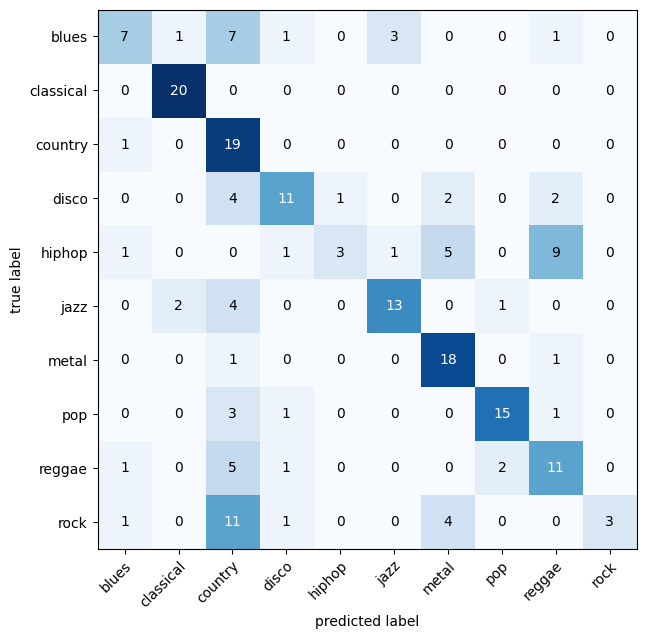

In [44]:
from helper_functions import plot_confmat
plot_confmat(model=model_2,
             test_data=test_data,
             class_names=class_names)

In [91]:
importlib.reload(cnn)
torch.manual_seed(19)
model_3 = cnn.AudioCNN_3(hidden_units=8).to(device)
model_3(test_data[0][0].unsqueeze(dim=0).to(device))
summary(model_3, input_size=[1,1,128,1000])


Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_3                               [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 63, 499]           --
│    └─Conv2d: 2-1                       [1, 8, 126, 998]          80
│    └─BatchNorm2d: 2-2                  [1, 8, 126, 998]          16
│    └─ReLU: 2-3                         [1, 8, 126, 998]          --
│    └─MaxPool2d: 2-4                    [1, 8, 63, 499]           --
├─Sequential: 1-2                        [1, 16, 30, 248]          --
│    └─Conv2d: 2-5                       [1, 16, 61, 497]          1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 61, 497]          32
│    └─ReLU: 2-7                         [1, 16, 61, 497]          --
│    └─MaxPool2d: 2-8                    [1, 16, 30, 248]          --
├─Sequential: 1-3                        [1, 32, 14, 123]          --
│    └─Conv2d: 2-9                       [1, 32, 28, 246]          4,640
│    └─Ba

In [92]:
importlib.reload(helper_functions)
from helper_functions import train

In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

model_3_results = train(model=model_3,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      scheduler=scheduler,
      epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.4729, Train acc: 0.1614 | Test loss: 5.5835, Test acc: 0.0893
Epoch: 1 | Train loss 1.9803, Train acc: 0.3042 | Test loss: 2.2237, Test acc: 0.2812
Epoch: 2 | Train loss 1.6651, Train acc: 0.3906 | Test loss: 2.0948, Test acc: 0.2812
Epoch: 3 | Train loss 1.4784, Train acc: 0.4897 | Test loss: 1.8789, Test acc: 0.3750
Epoch: 4 | Train loss 1.3122, Train acc: 0.5142 | Test loss: 1.7592, Test acc: 0.4375
Epoch: 5 | Train loss 1.2119, Train acc: 0.5870 | Test loss: 1.3284, Test acc: 0.5045
Epoch: 6 | Train loss 1.1662, Train acc: 0.5868 | Test loss: 1.2837, Test acc: 0.5045
Epoch: 7 | Train loss 1.1104, Train acc: 0.6133 | Test loss: 2.0461, Test acc: 0.4196
Epoch: 8 | Train loss 1.0506, Train acc: 0.6321 | Test loss: 2.1760, Test acc: 0.3661
Epoch: 9 | Train loss 0.9863, Train acc: 0.6659 | Test loss: 2.7449, Test acc: 0.2991
Epoch: 10 | Train loss 1.0171, Train acc: 0.6570 | Test loss: 1.5624, Test acc: 0.4420
Epoch: 11 | Train loss 0.8818, Train acc: 0.7048 | Te

  0%|          | 0/200 [00:00<?, ?it/s]

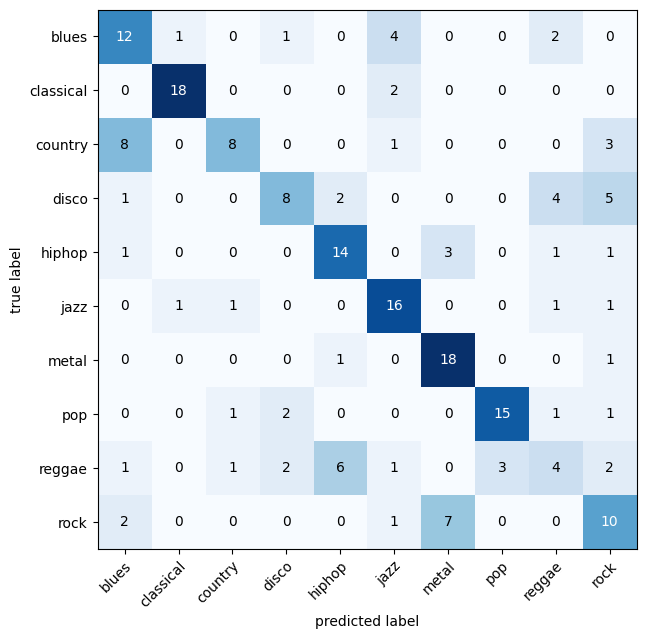

In [94]:
plot_confmat(model_3, test_data, class_names=class_names)

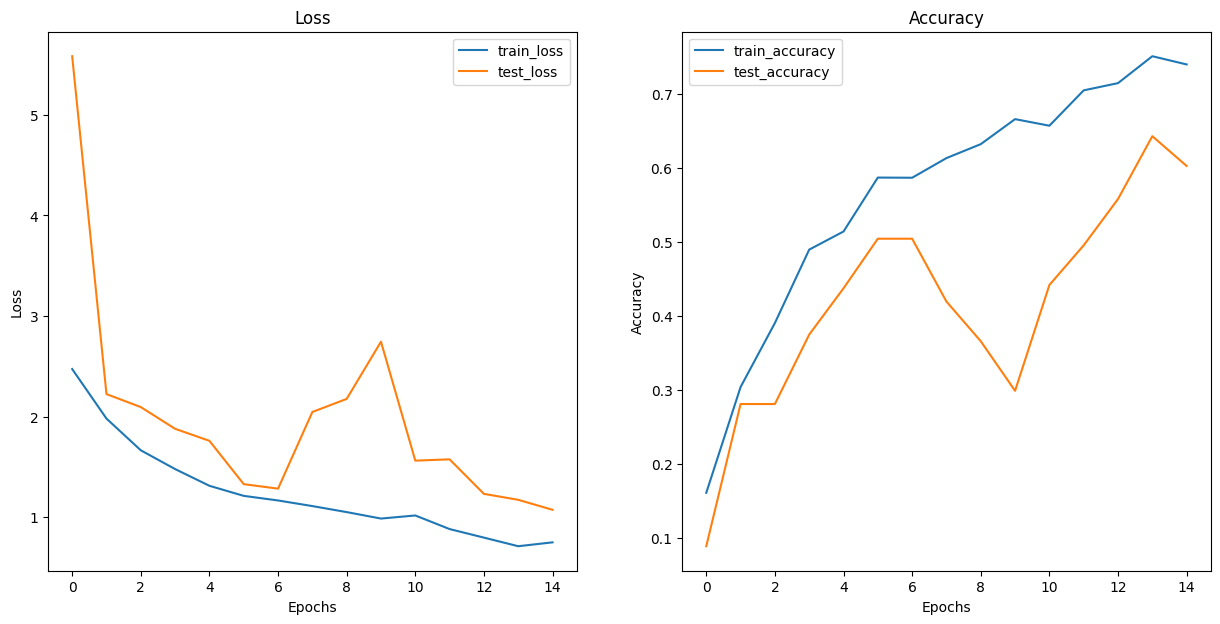

In [95]:
plot_loss_curves(results=model_3_results)

In [96]:
MODEL_PATH = Path("models")

MODEL_NAME = "AudioCNN_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\AudioCNN_3.pth


  0%|          | 0/200 [00:00<?, ?it/s]

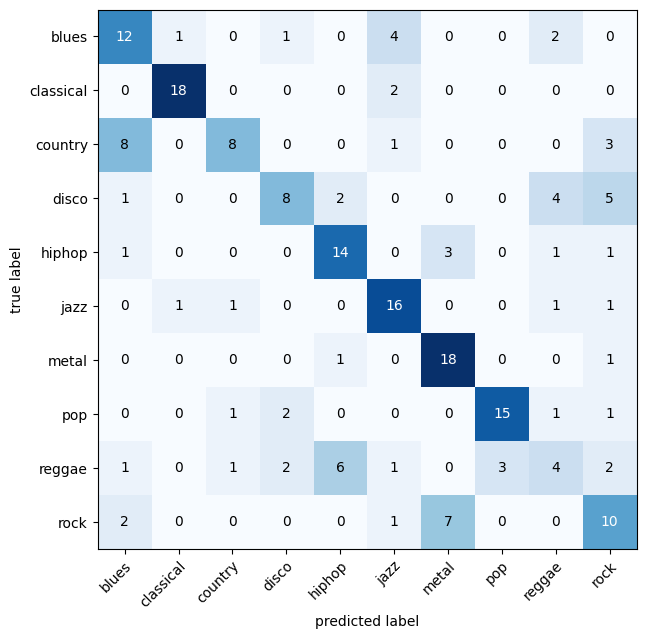

In [97]:
loaded_model_3 = cnn.AudioCNN_3(hidden_units=8)
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_3.to(device)

plot_confmat(loaded_model_3, test_data, class_names)